# Running MULTIGRIS (several runs and comparing results)

<font color=red>For best performance, it is advised to execute MULTIGRIS in the shell, as explained in the README. This notebook is just a way to illustrate a workflow. </font>

***
Motivations and goal
- How to run the [MULTIGRIS programs](https://gitlab.com/multigris) in batch scripts when dealing with several or many result directories.

The following context will be used:
- SFGX (star-forming galaxies with X-ray component; Ramambason et al. [2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..35R/abstract)) based on Cloudy models (Ferland et al. [2017](https://ui.adsabs.harvard.edu/abs/2017RMxAA..53..385F/abstract))

The various notebooks use some specific terms described in the file [TERMS.org](https://gitlab.com/multigris/mgris/-/blob/master/TERMS.org?ref_type=heads). 
***

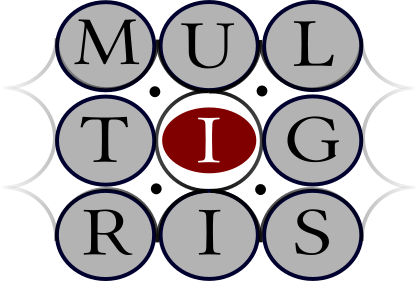

In [1]:
%load_ext autoreload
%autoreload 2
from wand.image import Image as WImage #this is to view PDFs
from IPython.display import Image
Image(filename='../Images/logo.png') 

## Table of contents:
* [Make one example model](#s1)
* [Gather/compile results](#s2)
* [Options](#s3)

## Imports and settings
***

In [2]:
import os 

import sys
sys.path.append('../') 

#arviz to read the PyMC3 trace
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

#imports to make input files
import importlib
import Library.lib_input
importlib.reload(Library.lib_input)
from Library.lib_input import *

#import the main MULTIGRIS scripts
import mgris_search, mgris_process, mgris_post_process, mgris_gather

#may need to run this if the script is interrupted
from Library.lib_main import closelogfiles

#to read the grid
import pandas as pd

#this is the input filename we'll use throughout, it will be automatically copied in the output directories each run
os.makedirs('./Runs/ISM_applications', exist_ok=True)
inputfile = './Runs/ISM_applications/input.txt' 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Checking path in case several copies exist

In [3]:
mgris_search.__file__

'/local/home/vleboute/work/MULTIGRIS/mgris/mgris_search.py'

## Make one example model <a class="anchor" id="s1"></a>
***

For these tests we use the grid itself as a solution and we will duplicate the model to make it easier and simulate a sample.

In [4]:
grid = pd.read_feather('../Contexts/mgris_sfgx/Grids/model_grid.fth').astype(np.float32)
params_name = ['age', 'n', 'u', 'Z', 'Lx', 'Tx', 'cut', 'lum', 'Z_dust']

#list of lines for which we wanna get the fluxes
lines = ['C2157.636m', 'O388.3323m', 'O163.1679m', 'N2205.244m', 'O1145.495m', 'Ne212.8101m', 'Ne315.5509m', 'N357.3238m', 'Ar26.98337m', 'Ar38.98898m', 'H217.0300m', 'Si234.8046m']

#required parameter set values, same order as params_name
models = [[0.477, 2, -2, -1.19, -2, 6, 2, 9, 0], ]

#mixing weight, 1 because single parameter set
ws = [1,]

#now we get the right row in the grid and get the fluxes
tmp = pd.DataFrame(models[0]).transpose().astype(np.float32)
tmp.columns = params_name

r = np.prod([grid[p]==tmp[p].iloc[0] for p in params_name], axis=0)
tmp2 = grid.loc[r==1].iloc[0]

del grid

obsfluxes = tmp2[lines].values

for i,o in enumerate(obsfluxes):
    print(lines[i], o)

C2157.636m 39.387
O388.3323m 39.761
O163.1679m 39.933
N2205.244m 36.187
O1145.495m 39.225
Ne212.8101m 38.087
Ne315.5509m 39.389
N357.3238m 38.556
Ar26.98337m 37.102
Ar38.98898m 38.548
H217.0300m 38.204
Si234.8046m 39.741


In [5]:
params = get_params()
params['context'].value = 'Contexts/mgris_sfgx'
output_directory = './Runs/ISM_applications/sample/'
params['output'].value = output_directory
params['USE configuration'].value = '1C1S'
params['select'].value = ['cut [2,2]', 'lum [9,9]', 'Z_dust [0,0]'] 
params['BEGIN observations'].value = '''{}'''.format('\n'.join([lines[i]+' '+str(o) for i,o in enumerate(obsfluxes)]))
params['BEGIN observations'].extras = {'delta_ref': 0.1, 'scale': 'log'}
params['use_scaling'].value = "'all'"
params['secondary_parameters'].value = ['MHII']
make_input(params, inputfile)

In [6]:
closelogfiles() #in case run was interrupted
mgris_search.main(args=mgris_search.args(inputfile=inputfile, order=0, nsamples_per_job=100))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍           ┑
     ┝ INFERENCE ┥
     ┕           ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INPUT PARAMETERS ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C1S

    ┍========================================┑
    ┝========= MULTIGRIS summary ============┥
    ┝========================================┙
    ┝ git version & date:
    ┝ - f9a3e3d (2024-08-29 15:48:55 +0200)
    ┝ - f9a3e3d
    ┝ git submodules:
    ┝ - 'Contexts/mgris_bond': 474a7c3, 'Contexts/mgris_loc': 78805da, 'Contexts/mgris_sfgx': dcd6f15 
    ┝========================================
    ┝ PyMC version  : 5.16.0
    ┝ Tensor library: pytensor
    ┝ - Compile directory:
    ┝   - /tmp/pytensor.NOBACKUP
    ┝ - Precision: float32
    ┕=============

[12  8  5  5  8  4  4]
-> [12  1  5  5  8  4  4]
[12  1  5  5  8  4  4]


u 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  5  8  4  4]
[12  1  1  5  8  4  4]


Z 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  8  4  4]
[12  1  1  1  8  4  4]


Lx 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  4  4]
[12  1  1  1  1  4  4]


Tx 0: single value (nearest neighbor grid interpolation)


-> [12  1  1  1  1  1  4]
[12  1  1  1  1  1  4]
-> [12  1  1  1  1  1  1]



Calculating prior predictive sample...
--------------------------------------
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_n_0, idx_u_0, scale]
Sampling: [idx_Lx_0, idx_Tx_0, idx_Z_0, idx_age_0, idx_n_0, idx_u_0, scale]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
idx_Lx_0         1.526  0.799   0.285    3.000      0.035    0.025     485.0   
idx_Tx_0         1.497  0.840   0.185    2.958      0.040    0.029     437.0   
idx_Z_0          3.362  1.926   0.094    6.437      0.096    0.068     400.0   
idx_age_0        3.477  1.943   0.086    6.546      0.084    0.060     526.0   
idx_n_0          1.979  1.086   0.139    3.804      0.050    0.036     472.0   
idx_u_0          1.965  1.065   0.102    3.651      0.049    0.035     479.0   
log_likelihood    -inf    NaN    -inf -131.698        NaN      NaN     474.0   
log_likelihood0   -inf    Na

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details

✨
✨✨
✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨
✨✨✨✨✨
✨✨
✨
✨✨
✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨ INFERENCE END
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨
✨✨✨✨
✨✨
✨
Inference ended     : 2024-08-30 19:56:46.379226
Time used 

Since we may be running the code for a large sample, we may wanna skip the generation of plots (they can always be redone from the saved InferenceData (netCDF) files)

In [7]:
closelogfiles() #in case run was interrupted
mgris_process.main(args=mgris_process.args(inputfile=inputfile, skip_plots=True))







       ┍ M U L ┑
       ┝ T I G ┥
       ┕ R I S ┙






     ┍            ┑
     ┝ PROCESSING ┥
     ┕            ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ READING INFERENCE DATA ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


-- Using pre-defined configuration 1C1S







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 30/08/2024 19:56:47
    ┕========================================┙
   







    ┍========================================┑
    ┝============= Run summary ==============┥
    ┝========================================┙
    ┝ - input file         : ./Runs/ISM_applications/input.txt
    ┝ - output directory   : ./Runs/ISM_applications/sample/
    ┕========================================┙
    
List 

In [8]:
closelogfiles() #in case run was interrupted
mgris_post_process.main(args=mgris_post_process.args(inputfile=inputfile, skip_plots=True))







          ┍ M U L ┑
          ┝ T I G ┥
          ┕ R I S ┙






     ┍                 ┑
     ┝ POST-PROCESSING ┥
     ┕                 ┙






Thanks for using MULTIGRIS.
Please make sure to check the README file, the notebooks, and the publication (https://ui.adsabs.harvard.edu/abs/2022A%26A...667A..34L/abstract).







    ┍========================================┑
    ┝=========== System summary =============┥
    ┝========================================┙
    ┝ Date/time:
    ┝ - 30/08/2024 19:56:52
    ┕========================================┙
   
-- Using pre-defined configuration 1C1S

    Run summary
    - input file         : ./Runs/ISM_applications/input.txt
    - output directory   : ./Runs/ISM_applications/sample/
    
Loading multi-trace...
Reading post-processing file ['post_processing_all_cutAv.fth', '#model_number']
Reading Feather file... /local/home/vleboute/work/MULTIGRIS/mgris/Contexts/mgris_sfgx/Grids/model_grid.fth (run pre-processing script if the lat

## Gather/compile results <a class="anchor" id="s2"></a>
***

For this example, we'll take 3 times the same result directory. 

It is also possible to provide the netCDF file names instead of the directories (e.g., if the netCDF files have been organized differently).

In [9]:
dirs = [output_directory, output_directory, output_directory]

In [10]:
closelogfiles() #in case run was interrupted
df = mgris_gather.main(args=mgris_gather.args(results=dirs, verbose=True))


▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ PREPARATION ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


First 10 entries:
['./Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/']
Will not save the resulting table, use -o to set output file name. 
Using trace_post-process files

Considered keys [initial] [25]: ['Ne315.5509m', 'O388.3323m', 'N2205.244m', 'MHII', 'O1145.495m', 'scale_eff', 'Lx_0', 'mask', 'u_0', 'scale', 'H217.0300m', 'n_0', 'age_0', 'log_likelihood', 'N357.3238m', 'C2157.636m', 'Ne212.8101m', 'Z_0', 'O163.1679m', 'Ar26.98337m', 'w_0', 'w', 'Tx_0', 'Ar38.98898m', 'Si234.8046m']

Final columns [107]: ['result', 'mean_Ne315.5509m', 'median_Ne315.5509m', 'hdi_lo_Ne315.5509m', 'hdi_up_Ne315.5509m', 'mean_O388.3323m', 'median_O388.3323m', 'hdi_lo_O388.3323m', 'hdi_up_O388.3323m', 'mean_N2205.244m', 'median_N2205.244m', 'hdi_lo_N2205.244m', 'hdi_up_N2205.244m', 'mean_MHII', 'median_MHII', 'hdi_lo_MHII', 'hdi_up_MHII', 'mean_O1145.495m', 'median_O1145.495m', 'hdi_lo_O1145.495m', 'hd

In [11]:
df

result  mean_Ne315.5509m  median_Ne315.5509m  hdi_lo_Ne315.5509m  \
0                39.388138           39.386238           39.327656   
1                39.388138           39.386238           39.327656   
2                39.388138           39.386238           39.327656   

   hdi_up_Ne315.5509m  mean_O388.3323m  median_O388.3323m  hdi_lo_O388.3323m  \
0           39.459255        39.762951          39.761589          39.694698   
1           39.459255        39.762951          39.761589          39.694698   
2           39.459255        39.762951          39.761589          39.694698   

   hdi_up_O388.3323m  mean_N2205.244m  ...  mean_Si234.8046m  \
0          39.828449        36.192322  ...          39.74501   
1          39.828449        36.192322  ...          39.74501   
2          39.828449        36.192322  ...          39.74501   

   median_Si234.8046m  hdi_lo_Si234.8046m  hdi_up_Si234.8046m     LOO  \
0           39.751354           39.672516           39.805363 -1.0762   
1           39.751354           39.672516           39.805363 -1.0762   
2           39.751354           39.672516           39.805363 -1.0762   

        LML  pnsigma1  pnsigma2  pnsigma3    pvalue  
0 -12.22268  0.980833  0.998333       1.0  0.064356  
1 -12.22268  0.980833  0.998333       1.0  0.064356  
2 -12.22268  0.980833  0.998333       1.0  0.064356  

[3 rows x 103 columns]

- The parameters from the processing and post-processing scripts are included by default but not the related parameters (e.g., component/group fractions, indices etc...)
- By default the mean, median, and highest density interval are saved for all keys in the inference data array. 
- Several metrics concerning the likelihood are also added by default. 
- The final table can also be saved using the -o option.

<font color=red>The above metrics (mean, median etc...) are useful when the posterior distribution is well behaved. However, the information about the draws, for instance needed to investigate KDEs and/or to examine whether the posterior distribution is multi-peaked, is lost. </font>

## Options <a class="anchor" id="s3"></a>
***

By default the directory/file name is used for the first column, but one can force another label and/or prepend/append any string:

In [12]:
closelogfiles() #in case run was interrupted
mgris_gather.main(args=mgris_gather.args(results=dirs, labels=['object1', 'object2', 'object3']))


▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ PREPARATION ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


First 10 entries:
['./Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/']
Will not save the resulting table, use -o to set output file name. 
Using trace_post-process files

Considered keys [initial] [25]: ['Ne315.5509m', 'O388.3323m', 'N2205.244m', 'MHII', 'O1145.495m', 'scale_eff', 'Lx_0', 'mask', 'u_0', 'scale', 'H217.0300m', 'n_0', 'age_0', 'log_likelihood', 'N357.3238m', 'C2157.636m', 'Ne212.8101m', 'Z_0', 'O163.1679m', 'Ar26.98337m', 'w_0', 'w', 'Tx_0', 'Ar38.98898m', 'Si234.8046m']

Final columns [107]: ['result', 'mean_Ne315.5509m', 'median_Ne315.5509m', 'hdi_lo_Ne315.5509m', 'hdi_up_Ne315.5509m', 'mean_O388.3323m', 'median_O388.3323m', 'hdi_lo_O388.3323m', 'hdi_up_O388.3323m', 'mean_N2205.244m', 'median_N2205.244m', 'hdi_lo_N2205.244m', 'hdi_up_N2205.244m', 'mean_MHII', 'median_MHII', 'hdi_lo_MHII', 'hdi_up_MHII', 'mean_O1145.495m', 'median_O1145.495m', 'hdi_lo_O1145.495m', 'hd

result  mean_Ne315.5509m  median_Ne315.5509m  hdi_lo_Ne315.5509m  \
0  object1         39.388138           39.386238           39.327656   
1  object2         39.388138           39.386238           39.327656   
2  object3         39.388138           39.386238           39.327656   

   hdi_up_Ne315.5509m  mean_O388.3323m  median_O388.3323m  hdi_lo_O388.3323m  \
0           39.459255        39.762951          39.761589          39.694698   
1           39.459255        39.762951          39.761589          39.694698   
2           39.459255        39.762951          39.761589          39.694698   

   hdi_up_O388.3323m  mean_N2205.244m  ...  mean_Si234.8046m  \
0          39.828449        36.192322  ...          39.74501   
1          39.828449        36.192322  ...          39.74501   
2          39.828449        36.192322  ...          39.74501   

   median_Si234.8046m  hdi_lo_Si234.8046m  hdi_up_Si234.8046m     LOO  \
0           39.751354           39.672516           39.805363 -1.0762   
1           39.751354           39.672516           39.805363 -1.0762   
2           39.751354           39.672516           39.805363 -1.0762   

        LML  pnsigma1  pnsigma2  pnsigma3    pvalue  
0 -12.22268  0.980833  0.998333       1.0  0.064356  
1 -12.22268  0.980833  0.998333       1.0  0.064356  
2 -12.22268  0.980833  0.998333       1.0  0.064356  

[3 rows x 103 columns]

In [13]:
closelogfiles() #in case run was interrupted
mgris_gather.main(args=mgris_gather.args(results=dirs, labels=['object1', 'object2', 'object3'], labels_prepend='architecture1_', labels_append='_TMP'))


▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ PREPARATION ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


First 10 entries:
['./Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/']
Will not save the resulting table, use -o to set output file name. 
Using trace_post-process files

Considered keys [initial] [25]: ['Ne315.5509m', 'O388.3323m', 'N2205.244m', 'MHII', 'O1145.495m', 'scale_eff', 'Lx_0', 'mask', 'u_0', 'scale', 'H217.0300m', 'n_0', 'age_0', 'log_likelihood', 'N357.3238m', 'C2157.636m', 'Ne212.8101m', 'Z_0', 'O163.1679m', 'Ar26.98337m', 'w_0', 'w', 'Tx_0', 'Ar38.98898m', 'Si234.8046m']

Final columns [107]: ['result', 'mean_Ne315.5509m', 'median_Ne315.5509m', 'hdi_lo_Ne315.5509m', 'hdi_up_Ne315.5509m', 'mean_O388.3323m', 'median_O388.3323m', 'hdi_lo_O388.3323m', 'hdi_up_O388.3323m', 'mean_N2205.244m', 'median_N2205.244m', 'hdi_lo_N2205.244m', 'hdi_up_N2205.244m', 'mean_MHII', 'median_MHII', 'hdi_lo_MHII', 'hdi_up_MHII', 'mean_O1145.495m', 'median_O1145.495m', 'hdi_lo_O1145.495m', 'hd

result  mean_Ne315.5509m  median_Ne315.5509m  \
0  architecture1_object1_TMP         39.388138           39.386238   
1  architecture1_object2_TMP         39.388138           39.386238   
2  architecture1_object3_TMP         39.388138           39.386238   

   hdi_lo_Ne315.5509m  hdi_up_Ne315.5509m  mean_O388.3323m  median_O388.3323m  \
0           39.327656           39.459255        39.762951          39.761589   
1           39.327656           39.459255        39.762951          39.761589   
2           39.327656           39.459255        39.762951          39.761589   

   hdi_lo_O388.3323m  hdi_up_O388.3323m  mean_N2205.244m  ...  \
0          39.694698          39.828449        36.192322  ...   
1          39.694698          39.828449        36.192322  ...   
2          39.694698          39.828449        36.192322  ...   

   mean_Si234.8046m  median_Si234.8046m  hdi_lo_Si234.8046m  \
0          39.74501           39.751354           39.672516   
1          39.74501           39.751354           39.672516   
2          39.74501           39.751354           39.672516   

   hdi_up_Si234.8046m     LOO       LML  pnsigma1  pnsigma2  pnsigma3  \
0           39.805363 -1.0762 -12.22268  0.980833  0.998333       1.0   
1           39.805363 -1.0762 -12.22268  0.980833  0.998333       1.0   
2           39.805363 -1.0762 -12.22268  0.980833  0.998333       1.0   

     pvalue  
0  0.064356  
1  0.064356  
2  0.064356  

[3 rows x 103 columns]

By default all keys from the inference data array are used, but we can force to gather only some keys:

In [14]:
closelogfiles() #in case run was interrupted
mgris_gather.main(args=mgris_gather.args(results=dirs, keys=['age_0']))


▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ PREPARATION ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


First 10 entries:
['./Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/']
Will not save the resulting table, use -o to set output file name. 
Using trace_post-process files

Considered keys [initial] [1]: ['age_0']

Final columns [11]: ['result', 'mean_age_0', 'median_age_0', 'hdi_lo_age_0', 'hdi_up_age_0', 'LOO', 'LML', 'pnsigma1', 'pnsigma2', 'pnsigma3', 'pvalue']
100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ CLEANING TABLE ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓



▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ FINAL TABLE ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


  result  mean_age_0  median_age_0  hdi_lo_age_0  hdi_up_age_0     LOO  \
0           0.474529      0.484011      0.247501      0.648242 -1.0762   
1           0.474529      0.484011      0.247501      0.648242 -1.0762   
2           0.474529      0.484011      0.247501      0.648242 -1.0762   

        LML  pn

result  mean_age_0  median_age_0  hdi_lo_age_0  hdi_up_age_0     LOO  \
0           0.474529      0.484011      0.247501      0.648242 -1.0762   
1           0.474529      0.484011      0.247501      0.648242 -1.0762   
2           0.474529      0.484011      0.247501      0.648242 -1.0762   

        LML  pnsigma1  pnsigma2  pnsigma3    pvalue  
0 -12.22268  0.980833  0.998333       1.0  0.064356  
1 -12.22268  0.980833  0.998333       1.0  0.064356  
2 -12.22268  0.980833  0.998333       1.0  0.064356

It is possible to add a prefix/suffix to all columns (e.g., in case the output table needs to be merged with another):

In [15]:
closelogfiles() #in case run was interrupted
mgris_gather.main(args=mgris_gather.args(results=dirs, prefix='set1'))


▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ PREPARATION ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


First 10 entries:
['./Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/']
Will not save the resulting table, use -o to set output file name. 
Using trace_post-process files

Considered keys [initial] [25]: ['Ne315.5509m', 'O388.3323m', 'N2205.244m', 'MHII', 'O1145.495m', 'scale_eff', 'Lx_0', 'mask', 'u_0', 'scale', 'H217.0300m', 'n_0', 'age_0', 'log_likelihood', 'N357.3238m', 'C2157.636m', 'Ne212.8101m', 'Z_0', 'O163.1679m', 'Ar26.98337m', 'w_0', 'w', 'Tx_0', 'Ar38.98898m', 'Si234.8046m']

Final columns [107]: ['result', 'mean_Ne315.5509m', 'median_Ne315.5509m', 'hdi_lo_Ne315.5509m', 'hdi_up_Ne315.5509m', 'mean_O388.3323m', 'median_O388.3323m', 'hdi_lo_O388.3323m', 'hdi_up_O388.3323m', 'mean_N2205.244m', 'median_N2205.244m', 'hdi_lo_N2205.244m', 'hdi_up_N2205.244m', 'mean_MHII', 'median_MHII', 'hdi_lo_MHII', 'hdi_up_MHII', 'mean_O1145.495m', 'median_O1145.495m', 'hdi_lo_O1145.495m', 'hd

result  set1_mean_Ne315.5509m  set1_median_Ne315.5509m  \
0                     39.388138                39.386238   
1                     39.388138                39.386238   
2                     39.388138                39.386238   

   set1_hdi_lo_Ne315.5509m  set1_hdi_up_Ne315.5509m  set1_mean_O388.3323m  \
0                39.327656                39.459255             39.762951   
1                39.327656                39.459255             39.762951   
2                39.327656                39.459255             39.762951   

   set1_median_O388.3323m  set1_hdi_lo_O388.3323m  set1_hdi_up_O388.3323m  \
0               39.761589               39.694698               39.828449   
1               39.761589               39.694698               39.828449   
2               39.761589               39.694698               39.828449   

   set1_mean_N2205.244m  ...  set1_mean_Si234.8046m  set1_median_Si234.8046m  \
0             36.192322  ...               39.74501                39.751354   
1             36.192322  ...               39.74501                39.751354   
2             36.192322  ...               39.74501                39.751354   

   set1_hdi_lo_Si234.8046m  set1_hdi_up_Si234.8046m  set1_LOO  set1_LML  \
0                39.672516                39.805363   -1.0762 -12.22268   
1                39.672516                39.805363   -1.0762 -12.22268   
2                39.672516                39.805363   -1.0762 -12.22268   

   set1_pnsigma1  set1_pnsigma2  set1_pnsigma3  set1_pvalue  
0       0.980833       0.998333            1.0     0.064356  
1       0.980833       0.998333            1.0     0.064356  
2       0.980833       0.998333            1.0     0.064356  

[3 rows x 103 columns]

Default operators include mean, median, and HDI, but we can add some (as long as they are methods for the inference data array):

In [16]:
closelogfiles() #in case run was interrupted
mgris_gather.main(args=mgris_gather.args(results=dirs, keys=['age_0'], operators='mean, median, hdi, min, max'))


▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ PREPARATION ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


First 10 entries:
['./Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/']
Will not save the resulting table, use -o to set output file name. 
Using trace_post-process files

Considered keys [initial] [1]: ['age_0']

Final columns [13]: ['result', 'mean_age_0', 'median_age_0', 'hdi_lo_age_0', 'hdi_up_age_0', 'min_age_0', 'max_age_0', 'LOO', 'LML', 'pnsigma1', 'pnsigma2', 'pnsigma3', 'pvalue']
100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.82it/s]

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ CLEANING TABLE ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓



▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ FINAL TABLE ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


  result  mean_age_0  median_age_0  hdi_lo_age_0  hdi_up_age_0  min_age_0  \
0           0.474529      0.484011      0.247501      0.648242   0.133898   
1           0.474529      0.484011      0.247501      0.648242   0.133898   
2           0.474529      0.484011      0.247501      0

result  mean_age_0  median_age_0  hdi_lo_age_0  hdi_up_age_0  min_age_0  \
0           0.474529      0.484011      0.247501      0.648242   0.133898   
1           0.474529      0.484011      0.247501      0.648242   0.133898   
2           0.474529      0.484011      0.247501      0.648242   0.133898   

   max_age_0     LOO       LML  pnsigma1  pnsigma2  pnsigma3    pvalue  
0   0.769205 -1.0762 -12.22268  0.980833  0.998333       1.0  0.064356  
1   0.769205 -1.0762 -12.22268  0.980833  0.998333       1.0  0.064356  
2   0.769205 -1.0762 -12.22268  0.980833  0.998333       1.0  0.064356

It is possible to add several combinations of existing columns which will be interpreted literally. To produce metrics for columns that don't exist but that can be calculated from existing ones, it is indeed preferable to perform the calculation on each draw before applying the operator, since mean(x)+mean(y) is not equal to mean(x+y)

In [17]:
closelogfiles() #in case run was interrupted
mgris_gather.main(args=mgris_gather.args(results=dirs, combinations={'OI/CII': 'C2157.636m-O163.1679m'}, keys=['age_0', 'OI/CII'], operators='mean, median, hdi, min, max'))


▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ PREPARATION ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


First 10 entries:
['./Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/', './Runs/ISM_applications/sample/']
Will not save the resulting table, use -o to set output file name. 
Using trace_post-process files

Considered keys [initial] [2]: ['OI/CII', 'age_0']

Final columns [19]: ['result', 'mean_OI/CII', 'median_OI/CII', 'hdi_lo_OI/CII', 'hdi_up_OI/CII', 'min_OI/CII', 'max_OI/CII', 'mean_age_0', 'median_age_0', 'hdi_lo_age_0', 'hdi_up_age_0', 'min_age_0', 'max_age_0', 'LOO', 'LML', 'pnsigma1', 'pnsigma2', 'pnsigma3', 'pvalue']
100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.15it/s]

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ CLEANING TABLE ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓



▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
▓ FINAL TABLE ▓
▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓


  result  mean_OI/CII  median_OI/CII  hdi_lo_OI/CII  hdi_up_OI/CII  \
0           -0.542179      -0.545998         -0.555      -0.515999   
1           -0.542179      -0.545998      

result  mean_OI/CII  median_OI/CII  hdi_lo_OI/CII  hdi_up_OI/CII  \
0           -0.542179      -0.545998         -0.555      -0.515999   
1           -0.542179      -0.545998         -0.555      -0.515999   
2           -0.542179      -0.545998         -0.555      -0.515999   

   min_OI/CII  max_OI/CII  mean_age_0  median_age_0  hdi_lo_age_0  \
0      -0.591   -0.489998    0.474529      0.484011      0.247501   
1      -0.591   -0.489998    0.474529      0.484011      0.247501   
2      -0.591   -0.489998    0.474529      0.484011      0.247501   

   hdi_up_age_0  min_age_0  max_age_0     LOO       LML  pnsigma1  pnsigma2  \
0      0.648242   0.133898   0.769205 -1.0762 -12.22268  0.980833  0.998333   
1      0.648242   0.133898   0.769205 -1.0762 -12.22268  0.980833  0.998333   
2      0.648242   0.133898   0.769205 -1.0762 -12.22268  0.980833  0.998333   

   pnsigma3    pvalue  
0       1.0  0.064356  
1       1.0  0.064356  
2       1.0  0.064356

Finally, other options exist:
- selecting a random subset among all inputs
- merging draws from all inputs and possibly select a random sample of draws
- include columnds corresponding to p-values, fractions, or indices

In [18]:
closelogfiles() #in case run was interrupted
#this is just an example
#mgris_gather.main(args=mgris_gather.args(result=dirs, new={"s2s2": "S__2_671644A / S__2_673082A", "n2s2": "N__2_658345A / ( S__2_671644A + S__2_673082A )"}))

Finally, if combining results with keys that don't exist in every result file, the code will stop by default but it is possible to force adding new columns in the final table with the -a option. 

## Going further <a class="anchor" id="s9"></a>
***

- Check this [notebook](2_How_to_run_number_of_samples.ipynb) to assess the number of samples.
- Check this [notebook](3_How_to_run_convergence_checks.ipynb) to improve the runs and the diagnostics.
- Check this [notebook](4_How_to_run_advanced.ipynb) to explore other options for each step.
- Check the [ISM application notebooks](ISM_applications.ipynb) for in-depth examples.